### MNIST-RNN
- [참고]
  - http://www.modulabs.co.kr/DeepLAB_free/2107
  - https://github.com/tgjeon/TensorFlow-Tutorials-for-Time-Series/blob/master/mnist-rnn.ipynb

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
print(tf.__version__)

1.1.0


In [2]:
mnist = input_data.read_data_sets("../MNIST_data/", one_hot=True)

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
# configuration
#                        output[-1] * W + b -> 10 labels for each image, output[-1]:[? 28], W:[28 10], B:[10]
#                       ^ (O: output 28 vec from 28 vec input)
#                       |
#      +-+  +-+       +--+
#      |1|->|2|-> ... |28| n_steps = 28
#      +-+  +-+       +--+
#       ^    ^    ...  ^
#       |    |         |
# img1:[28] [28]  ... [28]
# img2:[28] [28]  ... [28]
# img3:[28] [28]  ... [28]
# ...
# img128 or img256 (batch_size or test_size 256)
# each n_inputs = n_state_units = 28

In [4]:
batch_size = 128
n_inputs = 28
n_steps = 28
n_state_units = 28
learning_rate = 0.001
n_classes = 10

with tf.variable_scope("foo"):
    x = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
    xt = tf.transpose(x, perm = [1, 0, 2])
    xr = tf.reshape(xt, shape = [-1, n_inputs])
    xs = tf.split(value=xr, num_or_size_splits=n_steps, axis=0)

    rnn_cell = tf.contrib.rnn.BasicRNNCell(num_units = n_state_units)
    #rnn_cell = tf.contrib.rnn.BasicLSTMCell(num_units = n_state_units, forget_bias=1.0)
    outputs, state = tf.contrib.rnn.static_rnn(rnn_cell, xs, dtype=tf.float32)

    print(rnn_cell.output_size)
    print(len(outputs))
    print(outputs[-1])

    W = tf.Variable(tf.random_normal([n_state_units, n_classes]))
    B = tf.Variable(tf.random_normal([n_classes]))

    pred = tf.matmul(outputs[-1], W) + B

    y = tf.placeholder(tf.float32, [None, n_classes])

    error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(error)

    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

28
28
Tensor("foo/rnn/basic_rnn_cell_27/Tanh:0", shape=(?, 28), dtype=float32)


In [5]:
def printLossAccuracyForTestData(epoch, sess, test_accuracy_list):
    test_data = mnist.test.images.reshape((-1, n_steps, n_inputs))
    test_labels = mnist.test.labels
    accuracy_value, error_value = sess.run((accuracy, error), feed_dict={x: test_data, y: test_labels})
    test_accuracy_list.append(accuracy_value)
    print("epoch: {0}, test_error_value: {1}, test accuracy: {2}".format(epoch, error_value, accuracy_value))

def drawErrorValues(epoch_list, train_error_value_list, validation_error_value_list, test_accuracy_list):
    fig = plt.figure(figsize=(20, 5))
    plt.subplot(121)
    plt.plot(epoch_list, train_error_value_list, 'r', label='Train')
    plt.plot(epoch_list, validation_error_value_list, 'g', label='Validation')
    plt.ylabel('Total Error')
    plt.xlabel('Epochs')
    plt.grid(True)
    plt.legend(loc='upper right')

    plt.subplot(122)
    plt.plot(epoch_list, test_accuracy_list, 'b', label='Test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.yticks(np.arange(min(test_accuracy_list), max(test_accuracy_list), 0.05))
    plt.grid(True)
    plt.legend(loc='lower right')            
    plt.show()
    
def drawFalsePrediction(epoch, sess, numPrintImages):
    test_data = mnist.test.images.reshape((-1, n_steps, n_inputs))
    test_labels = mnist.test.labels
    correct_pred_value = sess.run(correct_pred, feed_dict={x: test_data, y: test_labels})
    ground_truth = sess.run(tf.argmax(y, 1), feed_dict={y: test_labels})
    prediction = sess.run(tf.argmax(pred, 1), feed_dict={x: test_data})

    fig = plt.figure(figsize=(20, 5))
    j = 1
    for i in range(len(correct_pred_value)):
        if (j > numPrintImages):
            break;
        if (not correct_pred_value[i]):
            ground_truth_num = mnist.test.labels[i]
            print("Error Index: {0}, Prediction: {1}, Ground Truth: {2}".format(i, prediction[i], ground_truth[i]))
            img = np.array(mnist.test.images[i])
            img.shape = (28, 28)
            plt.subplot(1, numPrintImages, j)
            plt.imshow(img)
            j += 1

mnist.train.num_examples 55000
batch_size 128
Total batch: 430
epoch: 0, test_error_value: 0.8890829086303711, test accuracy: 0.7020000219345093
epoch: 1, test_error_value: 0.6240018606185913, test accuracy: 0.8039000034332275
epoch: 2, test_error_value: 0.4960932731628418, test accuracy: 0.8479999899864197
train complete!


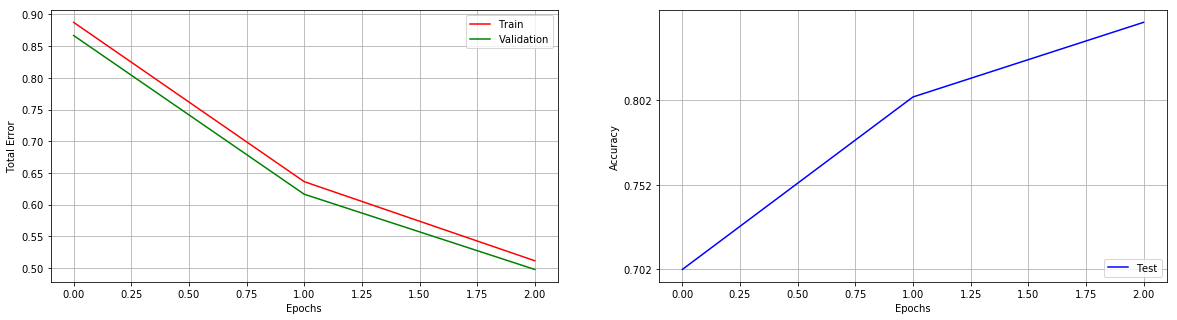

Error Index: 7, Prediction: 1, Ground Truth: 9
Error Index: 8, Prediction: 0, Ground Truth: 5
Error Index: 18, Prediction: 2, Ground Truth: 3
Error Index: 33, Prediction: 6, Ground Truth: 4
Error Index: 48, Prediction: 9, Ground Truth: 4
Error Index: 59, Prediction: 8, Ground Truth: 5
Error Index: 61, Prediction: 6, Ground Truth: 8
Error Index: 62, Prediction: 4, Ground Truth: 9
Error Index: 73, Prediction: 7, Ground Truth: 9
Error Index: 80, Prediction: 2, Ground Truth: 7


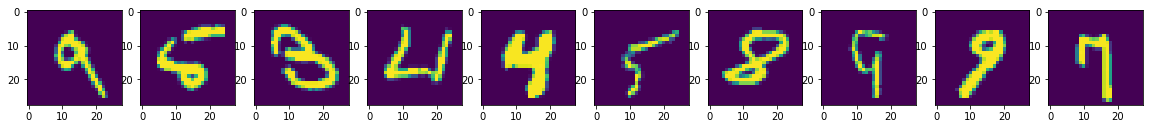

In [7]:
init = tf.global_variables_initializer()

display_step = 1
max_training_epochs = 3
batch_size = 128
n_inputs = 28
n_steps = 28

epoch_list                  = []
train_error_value_list      = []
validation_error_value_list = []
test_error_value_list       = []
test_accuracy_list          = []

with tf.Session() as sess:
    sess.run(init)
    
    print("mnist.train.num_examples", mnist.train.num_examples)
    print("batch_size", batch_size)
    total_batch = int(math.ceil(mnist.train.num_examples / float(batch_size)))
    print("Total batch: {0}".format(total_batch))
    
    for epoch in range(max_training_epochs):
        for i in range(total_batch):
            batch_images, batch_labels = mnist.train.next_batch(batch_size)
            batch_images = batch_images.reshape((batch_size, n_steps, n_inputs))
            sess.run((optimizer, error), feed_dict={x: batch_images, y: batch_labels})
        
        epoch_list.append(epoch)
        
        t_images = mnist.train.images.reshape((mnist.train.num_examples, n_steps, n_inputs))
        t_labels = mnist.train.labels
        t_error_value = sess.run(error, feed_dict={x: t_images, y: t_labels})
        train_error_value_list.append(t_error_value)
        
        v_images = mnist.validation.images.reshape((mnist.validation.num_examples, n_steps, n_inputs))
        v_labels = mnist.validation.labels
        v_error_value = sess.run(error, feed_dict={x: v_images, y: v_labels})
        validation_error_value_list.append(v_error_value)
            
        printLossAccuracyForTestData(epoch, sess, test_accuracy_list)
            
    print("train complete!")
    drawErrorValues(epoch_list, train_error_value_list, validation_error_value_list, test_accuracy_list)
    drawFalsePrediction(epoch, sess, 10)